# Project: Battle of Neighborhoods

## _Moving Out: Helping an international Student_

## Daniel M. Miranda


#### The idea behind this project is to find out which are the best apartment options for an international student from Rio de Janeiro, based on rent price, location and ways of transportation, in this case subway. Venues around the neighborhood is a key factor too, because it's important to keep the surround of the student similar to his current neighborhood, to make easier to adapt to the new country.

<strong> Contents: <strong/>
1. Introduction
    
    1.1. The situation that leads to a problem
    
    1.2. The problem to be solved    
2. Data
    
    2.1. Data required to solve the problem
        
3. Methodology
    
    3.1. Steps the reach solution
    
4. Results
    
    4.1. Results from the project and decisions based on the result

## 1. Introduction

### 1.1. The situation that leads to a problem

The objective of this project is to suggest apartment options to a student who is moving to Toronto in order to study at the Toronto university.   
The decision is based on the location of the apartment and rental price. The student needs a apartment close to the university campus or a rent option that offers another way of transportation to the universtity (in this project, only subway will be considered).

### 1.2. The problem to be solved

Find the best option for the international student to rent an apartment, considering all the key factors in order to minimize the costs and yet, keep the surround of the student similar to his current neighborhood.
To do that, it's important to start analyzing the current neighborhood of the student, finding out which type of venues are more frequent around the area. To collect data from venues around neighborhoods, we'll be using the **Foursquare API**.    
Next, we must create a list of the most frequent type of venues for each neighborhood in Toronto. After that, we'll be able to decide which neighborhoods are the most similar to the birth city of the student.

## 2. Data

### 2.1. Data required to solve the problem

The data required to find out a solution for the best rent option includes: 
* Available options for rent (including: rental price, address, latitude, longitude, number of bedrooms) 
* List of subway stations of the city (including: station name, address, latitude, longitude)
* Data about venues from the birth city of the international student
* Data about venues in each neighborhood in Toronto


### 2.2. Data sources

Information about rental data in Toronto can easily be found in Kaggle datasets (https://www.kaggle.com/rajacsp/toronto-apartment-price).
This dataset however, has not been updated since January. To complement the data, I scraped a rental website from Toronto and collected some more data. The website scraped was https://toronto.craigslist.org/search/ap.

The subway data could be found in a blogpost, available in CSV format. Here’s the link to access the website: http://scruss.com/blog/2005/12/14/toronto-subway-station-gps-locations/.

Information about venues from Toronto were part of another project, and are already done. In case you’re interested in checking it out, here’s the link: https://github.com/danielmmir/Coursera_Capstone/blob/master/Scraping_Neigh_data_Toronto.ipynb.


### 2.3. Data manipulation

After collecting all the necessary data, I started preparing them to be used in my project, since most of the data collected were not ready to be used. Here’s some adjustment I did to make sure the data were formatted the right way to be used in my main project:

•Rental dataset

The rental dataset collected from Kaggle had a problem with the price of the rent, since it was a ‘object’ Type, as we can see in the print taken from the jupyter Notebook.   
In order to be able to collect information about the rental prices (average, 25th quartile, 75th quartile, minimum, maximum, etc.) it was necessary transform the type to ‘float’.
After that, I had to clean all the rows with at least one empty entry.   
   
•Subway data

Since the data were downloaded separately for each line of the subway, the only thing to do was concatenate the data frames.


## 3. Methodology

### 3.1. Steps to reach the solution

In order to reach a solution, it's important to start analyzing the birth city of the student, finding out which type of venues are more frequent around the neighborhood where the student currently lives. To collect data from venues around neighborhoods, we'll be using the **Foursquare API**.    
Next, we must create a list of the most frequent type of venues for each neighborhood in Toronto. After that, we'll be able to decide which neighborhoods are the most similar to the birth city of the student.   
After that, the strategy is based on mapping results from the type of venues for each neighborhood in Toronto and the rental data, in order to facilitate the choice of at least two candidate places for rent. The choice is made based on the demands imposed: location near a subway, rental price and similar venues to the birth city of the student. This approach allows quick identification of location, price and feature, thus making the selection very easy.

The processing of these data and its mapping will allow to answer the key questions to make a decision:


- what is the cost of available rental places that meet the demands?   
- what is the area of Toronto with best rental pricing that meets criteria established?   
- What are the venues of the two best places to live? How the prices compare?   
- How venues distribute among Toronto neighborhoods ?   
- Are there tradeoffs between size and price and location?   
- Any other interesting statistical data findings of the real estate and overall data.  

### Starting with the libraries import

In [126]:
# Importing Libraries

import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json # library to handle JSON files
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
from bs4 import BeautifulSoup
import lxml
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Toronto rental data

In [22]:
rents = pd.read_csv('/Users/danielmiranda/Documents/Cursos/Coursera/IBM Data Science Professional Certificate/Curso 9 - Applied Data Science Capstone/5. Battle Of Neighborhoods/Data/Rental_toronto.csv',index_col=0)

In [23]:
# How the dataframe looks like

rents.tail(3)

Bedroom  Bathroom                                         Address  \
1121        1       1.0     Upper Beaches, Toronto, ON, Canada, M4C 1B4   
1122        2       1.0                    , Toronto M5B 2L7 ON, Canada   
1123        1       1.0  561 Sherbourne St, Toronto, ON M4X 0A1, Canada   

            Lat       Long  Rental Price  
1121  43.683386 -79.309409        1800.0  
1122  43.653636 -79.380873        2200.0  
1123  43.669931 -79.375463        2150.0

In [24]:
rents.dtypes

Bedroom           int64
Bathroom        float64
Address          object
Lat             float64
Long            float64
Rental Price    float64
dtype: object

In [25]:
# Quick information about the rent options available in Toronto

rents.describe()

Bedroom     Bathroom          Lat         Long  Rental Price
count  1119.000000  1119.000000  1119.000000  1119.000000   1119.000000
mean      1.369973     1.238606    43.703969   -79.500478   2175.334227
std       0.553757     0.432669     0.694144     1.764548    741.935955
min       1.000000     1.000000    42.985767  -114.082215     65.000000
25%       1.000000     1.000000    43.641350   -79.414319   1758.500000
50%       1.000000     1.000000    43.650560   -79.387295   2100.000000
75%       2.000000     1.000000    43.666130   -79.376994   2500.000000
max       3.000000     3.000000    56.130366   -73.576385   9750.000000

Using the describe tool, it's possible to say that the mean rental price around the city is 2.175.    
75th percentile is 2.500, which means this number is bigger than 75% of the rents, but it's smaller than 25%.

In [26]:
# Correlation between rental caracteristics

rents.corr()

Bedroom  Bathroom       Lat      Long  Rental Price
Bedroom       1.000000  0.635458  0.087199 -0.088944      0.396655
Bathroom      0.635458  1.000000  0.063071 -0.072244      0.494156
Lat           0.087199  0.063071  1.000000 -0.894068      0.052873
Long         -0.088944 -0.072244 -0.894068  1.000000     -0.073988
Rental Price  0.396655  0.494156  0.052873 -0.073988      1.000000

### Loading Toronto subway data

In [30]:
subway = pd.read_csv('/Users/danielmiranda/Documents/Cursos/Coursera/IBM Data Science Professional Certificate/Curso 9 - Applied Data Science Capstone/5. Battle Of Neighborhoods/Data/Toronto Subway/Subway_Toronto.csv', index_col=0)

In [31]:
subway.head()

Latitude  Longitude     Station
0  43.638020 -79.536388     Kipling
1  43.645950 -79.523948   Islington
2  43.648804 -79.511541  Royal York
3  43.650576 -79.495225    Old Mill
4  43.650291 -79.484772        Jane

In [33]:
subway.shape

(74, 3)

### Analyzing venues from the neighborhood of the student current home

In [74]:
# Current student address = Barra da tijuca, rio de janeiro, brasil
address = 'golden green, barra da tijuca, rio de janeiro, brasil'
geolocator = Nominatim(user_agent = "city_explorer")
location = geolocator.geocode(address)
current_latitude = location.latitude
current_longitude = location.longitude
print('The student current neighborhood latitude is {} and the longitude is {}'.format(current_latitude, current_longitude))

The student current neighborhood latitude is -23.0099979 and the longitude is -43.3482635


### Using FourSquare to find venues around current residence in Brazil

In [75]:
# Foursquare API credentials

CLIENT_ID = '5POPJZCPATN5LA5SWI3GBHRZXEIOODTEQNIFOUWXO1WEUBFF' # your Foursquare ID
CLIENT_SECRET = '4UU2LLVLV2MAAVFDORH40KSZKNMES323YYERWOEYDCSR5VNJ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5POPJZCPATN5LA5SWI3GBHRZXEIOODTEQNIFOUWXO1WEUBFF
CLIENT_SECRET:4UU2LLVLV2MAAVFDORH40KSZKNMES323YYERWOEYDCSR5VNJ


In [76]:
LIMIT = 150 # limit of number of venues returned by Foursquare API
RADIUS = 1500 # define radius of search

# creating URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    current_latitude, 
    current_longitude, 
    RADIUS, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=5POPJZCPATN5LA5SWI3GBHRZXEIOODTEQNIFOUWXO1WEUBFF&client_secret=4UU2LLVLV2MAAVFDORH40KSZKNMES323YYERWOEYDCSR5VNJ&v=20180605&ll=-23.0099979,-43.3482635&radius=1500&limit=150'

In [77]:
# results display is hidden for report simplification 

results = requests.get(url).json()

In [78]:
# This function extracts the category of the venue. It was borrowed from the Foursquare lab

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [79]:
venues = results['response']['groups'][0]['items']
SGnearby_venues = json_normalize(venues) # flatten JSON
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
SGnearby_venues =SGnearby_venues.loc[:, filtered_columns]
# filter the category for each row
SGnearby_venues['venue.categories'] = SGnearby_venues.apply(get_category_type, axis=1)
# clean columns
SGnearby_venues.columns = [col.split(".")[-1] for col in SGnearby_venues.columns]

SGnearby_venues.shape

(100, 4)

In [80]:
# Venues near current student residence place

SGnearby_venues.head(15)

name            categories        lat        lng
0                Windsor Marapendi                 Hotel -23.009734 -43.351354
1                Deli Golden Green         Deli / Bodega -23.009934 -43.350338
2          Novotel Barra da Tijuca                 Hotel -23.009942 -43.351312
3         Praia da Barra da Tijuca                 Beach -23.010654 -43.344461
4                          Posto 6          Bathing Area -23.010300 -43.344277
5                     Golden Sucos        Sandwich Place -23.009952 -43.350278
6                          Posto 7          Bathing Area -23.010342 -43.353454
7   Hotel Laghetto Stilo Barra Rio                 Hotel -23.009566 -43.353403
8                         Bodytech  Gym / Fitness Center -23.010077 -43.342172
9      Barrabella Hotel Residência                 Hotel -23.009137 -43.344867
10           Supermercado Zona Sul           Supermarket -23.009920 -43.345096
11              Gracie Barra Praia     Martial Arts Dojo -23.006299 -43.351604
12                        The Bife            Steakhouse -23.002715 -43.350476
13               Quiosque do Ceará             Beach Bar -23.010454 -43.350465
14     Academia de Dança Ramalho's          Dance Studio -23.009080 -43.340516

#### Visualizing venues around student current home

In [87]:
# creating map of current student place

map_sg = folium.Map(location=[current_latitude, current_longitude], zoom_start=14)

# adding markers to map

for lat, lng, label in zip(SGnearby_venues['lat'], SGnearby_venues['lng'], SGnearby_venues['name']):
    label = folium.Popup(label, parse_html=True)
    folium.RegularPolygonMarker(
        [lat, lng],
        number_of_sides=30,
        radius=7,
        popup=label,
        color='blue',
        fill_opacity=0,
    ).add_to(map_sg)  
    
map_sg

### Toronto neighborhoods

Cluster neighborhood data was produced with Foursquare during course lab work.

In [102]:
neigh_data = pd.read_csv('/Users/danielmiranda/Documents/Cursos/Coursera/IBM Data Science Professional Certificate/Curso 9 - Applied Data Science Capstone/5. Battle Of Neighborhoods/Data/nighborhood_toronto.csv', index_col=0)

In [131]:
neigh_data[neigh_data['Cluster Labels']==0.0].head(20)

Postcode      Borough                                       Neighborhood  \
0       M1B  Scarborough                                      Rouge,Malvern   
1       M1C  Scarborough               Highland Creek,Rouge Hill,Port Union   
2       M1E  Scarborough                    Guildwood,Morningside,West Hill   
3       M1G  Scarborough                                             Woburn   
4       M1H  Scarborough                                          Cedarbrae   
6       M1K  Scarborough          East Birchmount Park,Ionview,Kennedy Park   
7       M1L  Scarborough                      Clairlea,Golden Mile,Oakridge   
8       M1M  Scarborough      Cliffcrest,Cliffside,Scarborough Village West   
9       M1N  Scarborough                         Birch Cliff,Cliffside West   
10      M1P  Scarborough  Dorset Park,Scarborough Town Centre,Wexford He...   
11      M1R  Scarborough                                   Maryvale,Wexford   
12      M1S  Scarborough                                          Agincourt   
13      M1T  Scarborough              Clarks Corners,Sullivan,Tam O'Shanter   
15      M1W  Scarborough                                    L'Amoreaux West   
17      M2H   North York                                  Hillcrest Village   
18      M2J   North York                         Fairview,Henry Farm,Oriole   
19      M2K   North York                                    Bayview Village   
22      M2N   North York                                   Willowdale South   
24      M2R   North York                                    Willowdale West   
26      M3B   North York                                    Don Mills North   

     Latitude  Longitude  Cluster Labels  \
0   43.806686 -79.194353             0.0   
1   43.784535 -79.160497             0.0   
2   43.763573 -79.188711             0.0   
3   43.770992 -79.216917             0.0   
4   43.773136 -79.239476             0.0   
6   43.727929 -79.262029             0.0   
7   43.711112 -79.284577             0.0   
8   43.716316 -79.239476             0.0   
9   43.692657 -79.264848             0.0   
10  43.757410 -79.273304             0.0   
11  43.750071 -79.295849             0.0   
12  43.794200 -79.262029             0.0   
13  43.781638 -79.304302             0.0   
15  43.799525 -79.318389             0.0   
17  43.803762 -79.363452             0.0   
18  43.778517 -79.346556             0.0   
19  43.786947 -79.385975             0.0   
22  43.770120 -79.408493             0.0   
24  43.782736 -79.442259             0.0   
26  43.745906 -79.352188             0.0   

                        1st Most Common Venue  \
0         Venue Category_Fast Food Restaurant   
1   Venue Category_Construction & Landscaping   
2                 Venue Category_Intersection   
3                  Venue Category_Coffee Shop   
4             Venue Category_Hakka Restaurant   
6             Venue Category_Department Store   
7                     Venue Category_Bus Line   
8                        Venue Category_Motel   
9              Venue Category_College Stadium   
10           Venue Category_Indian Restaurant   
11   Venue Category_Middle Eastern Restaurant   
12                      Venue Category_Lounge   
13                 Venue Category_Pizza Place   
15        Venue Category_Fast Food Restaurant   
17                     Venue Category_Dog Run   
18              Venue Category_Clothing Store   
19         Venue Category_Japanese Restaurant   
22                  Venue Category_Restaurant   
24                    Venue Category_Pharmacy   
26                        Venue Category_Café   

                      2nd Most Common Venue  \
0                 Venue Category_Print Shop   
1                        Venue Category_Bar   
2                        Venue Category_Spa   
3          Venue Category_Convenience Store   
4                     Venue Category_Bakery   
6                 Venue Category_Playground   
7                     Venue Category_Bakery   
8        Ven

In [103]:
neigh_data.head(5)

Postcode      Borough                          Neighborhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  Cluster Labels                      1st Most Common Venue  \
0 -79.194353             0.0        Venue Category_Fast Food Restaurant   
1 -79.160497             0.0  Venue Category_Construction & Landscaping   
2 -79.188711             0.0                Venue Category_Intersection   
3 -79.216917             0.0                 Venue Category_Coffee Shop   
4 -79.239476             0.0            Venue Category_Hakka Restaurant   

              2nd Most Common Venue             3rd Most Common Venue  \
0         Venue Category_Print Shop       Venue Category_Dessert Shop   
1                Venue Category_Bar        Venue Category_Yoga Studio   
2                Venue Category_Spa  Venue Category_Electronics Store   
3  Venue Category_Convenience Store  Venue Category_Korean Restaurant   
4             Venue Category_Bakery             Venue Category_Lounge   

                        4th Most Common Venue  \
0                        Venue Category_Diner   
1  Venue Category_Eastern European Restaurant   
2                  Venue Category_Pizza Place   
3                  Venue Category_Yoga Studio   
4         Venue Category_Caribbean Restaurant   

                        5th Most Common Venue  \
0               Venue Category_Discount Store   
1                      Venue Category_Dog Run   
2               Venue Category_Breakfast Spot   
3  Venue Category_Eastern European Restaurant   
4           Venue Category_Athletics & Sports   

             6th Most Common Venue               7th Most Common Venue  \
0           Venue Category_Dog Run     Venue Category_Doner Restaurant   
1  Venue Category_Doner Restaurant           Venue Category_Donut Shop   
2      Venue Category_Tech Startup       Venue Category_Medical Center   
3           Venue Category_Dog Run     Venue Category_Doner Restaurant   
4              Venue Category_Bank  Venue Category_Fried Chicken Joint   

                8th Most Common Venue               9th Most Common Venue  \
0           Venue Category_Donut Shop            Venue Category_Drugstore   
1            Venue Category_Drugstore  Venue Category_Dumpling Restaurant   
2  Venue Category_Rental Car Location   Venue Category_Mexican Restaurant   
3           Venue Category_Donut Shop            Venue Category_Drugstore   
4      Venue Category_Thai Restaurant          Venue Category_Yoga Studio   

               10th Most Common Venue  
0  Venue Category_Dumpling Restaurant  
1    Venue Category_Electronics Store  
2              Venue Category_Dog Run  
3  Venue Category_Dumpling Restaurant  
4            Venue Category_Drugstore

In the dataframe above, we have all information about venues in each neighborhood from Toronto. For more information about how to collect this type of data, check out the **'Scraping_Neigh_data_Toronto'** notebook.

In [94]:
# Discovering Toronto's coordinates

location2 = geolocator.geocode('toronto, canada')
toronto_latitude = location2.latitude
toronto_longitude = location2.longitude

print("Toronto's coordinates:{},{}".format(toronto_latitude,toronto_longitude))

Toronto's coordinates:43.653963,-79.387207


### Visualizing Toronto clusters based on venues types

In [123]:
kclusters=5
map_clusters = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neigh_data['Latitude'], neigh_data['Longitude'], neigh_data['Neighborhood'], neigh_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters)
  # add markers for rental places to map
for lat, lng, label in zip(neigh_data['Latitude'], neigh_data['Longitude'], neigh_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters)    
    
       
map_clusters

**Conclusion**: After considering the types of venues of each cluster, and considering the venues around the current home of the student, the most similar borough to live is Downtown Toronto (cluster 0).

### Studying apartment rents price

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


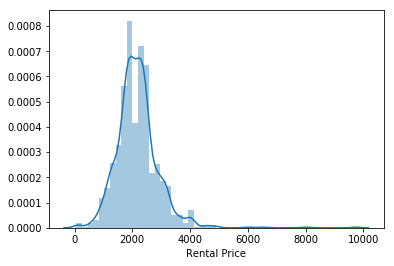

In [127]:
sns.distplot(rents["Rental Price"])

We can se that most of the rental prices are around 2.000,00

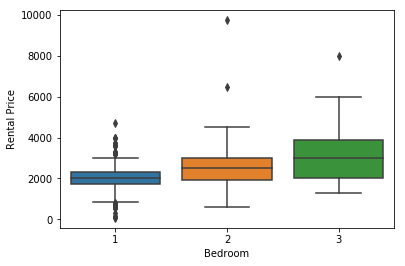

In [130]:
sns.boxplot(x='Bedroom', y= 'Rental Price', data=rents)

We can see that the price of the rent increases depending on the nuber of bedrooms. More bedrooms, a more expensive rent, in general.

### visualizing apartments for rent

In [137]:
# create map of Toronto using latitude and longitude values from Nominatim

map_toronto_rent = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=12)

# add markers to show apartment options
for lat, lng, label in zip(rents['Lat'], rents['Long'],'$ ' + rents['Rental Price'].astype(str)):      
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto_rent) 
    

map_toronto_rent

As we can see above, we have a lot of options around the neighborhood selected after the location study.

### Creating a view with apartments and clusters

In [153]:
# create map with clusters
kclusters=5
map_clusters2 = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add cluster markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neigh_data['Latitude'], neigh_data['Longitude'], neigh_data['Neighborhood'], neigh_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters2)

# add markers to map for rental places
for lat, lng, label in zip(rents['Lat'], rents['Long'],'$ ' + rents['Rental Price'].astype(str)):      
    label = folium.Popup('lat:'+str(lat)+', long:'+str(lng) + ', Rental price:'+label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_clusters2)  
    
    # Adds tool to the top
from folium.plugins import MeasureControl
map_toronto_rent.add_child(MeasureControl())


map_clusters2

### As we can see in the image above, there are several good options for the student.
### In order to keep the costs of transportation as minimun as possible, and keeping in mind the student wants to live in a enviromment that is similar to the enviromment of his current neighborhood, 2 options were selected:

### Option 1: Mininum cost

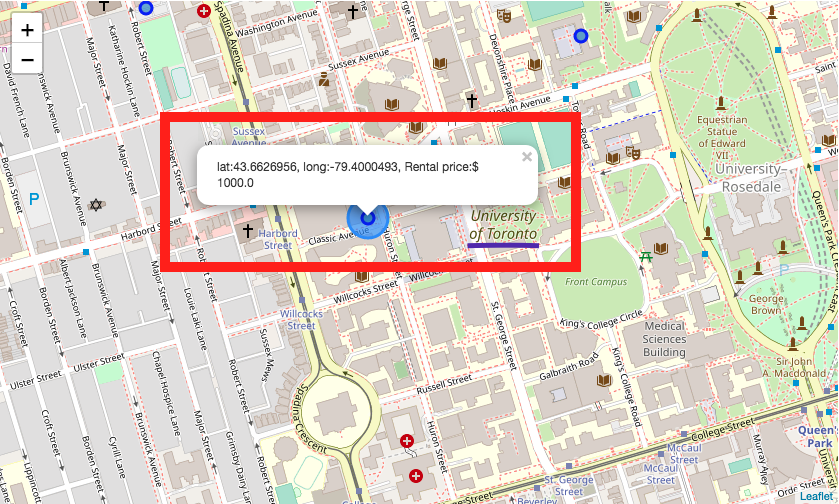

In [154]:
from IPython.display import Image
Image(filename='/Users/danielmiranda/Documents/Cursos/Coursera/IBM Data Science Professional Certificate/Curso 9 - Applied Data Science Capstone/5. Battle Of Neighborhoods/Data/option1.png',width=800, height=400)

In [156]:
rents[rents['Lat']==43.6626956]

Bedroom  Bathroom      Address        Lat       Long  Rental Price
1003        1       1.0  M5S, Canada  43.662696 -79.400049        1000.0

**Conclusion**: This option counts with 1 bedroom and 1 bathroom, right in front of the university campus. But, this apartment is not close to the subway station.

### Creating a view with apartment options, metro subway stations and clusters

In [166]:
# create map with clusters
kclusters=5
map_clusters3 = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=14)


#adding clusters markers to the map
for lat, lon, poi, cluster in zip(neigh_data['Latitude'], neigh_data['Longitude'], neigh_data['Neighborhood'], neigh_data['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        fill=True,
        fill_opacity=0.7).add_to(map_clusters3)

# add subway markers to the map
for lat, lon, station in zip(subway['Latitude'], subway['Longitude'], subway['Station']):
    label = folium.Popup(station + ', Latitude:' + str(lat)+', Longitude:'+str(lon), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=20,
        popup=label,
        color='red',
        fill=True,
        fill_opacity=0).add_to(map_clusters3)

# add markers to map for rental places
for lat, lng, label in zip(rents['Lat'], rents['Long'],'$ ' + rents['Rental Price'].astype(str)):      
    label = folium.Popup('lat:'+str(lat)+', long:'+str(lng) + ', Rental price:'+label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0,
        parse_html=False).add_to(map_clusters3)  
 


    # Adds tool to the top
from folium.plugins import MeasureControl
map_toronto_rent.add_child(MeasureControl())


map_clusters3

### Option 2: More expensive, but close to the subway

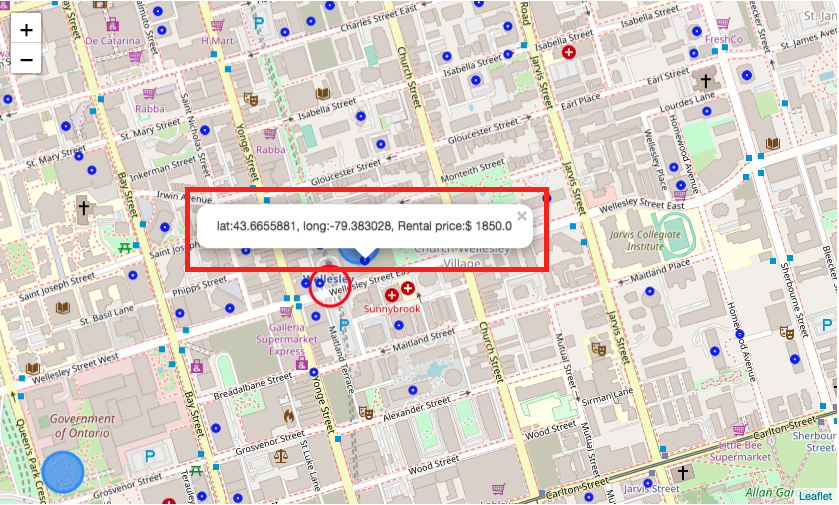

In [167]:
Image(filename='/Users/danielmiranda/Documents/Cursos/Coursera/IBM Data Science Professional Certificate/Curso 9 - Applied Data Science Capstone/5. Battle Of Neighborhoods/Data/option2.png',width=800, height=400)

In [165]:
rents[(rents['Lat']==43.6655881) & (rents['Rental Price']==1850.0)]

Bedroom  Bathroom                                     Address  \
1026        1       1.0  28 Wellesley St E, Toronto, ON M4Y, Canada   

            Lat       Long  Rental Price  
1026  43.665588 -79.383028        1850.0

**Conclusion**: This option counts with one bedroom and 1 bathroom as well, but it's next to the subway station.

## 4. Results

### 4.1. Results from the project and decisions based on the result

Using the maps above, I was able to explore all possibilities since the popups provide the information needed for a good decision.

Therefore, 2 apartments where selected, since they attend all key features necessary.

#### Option 1:
This option counts with 1 bedroom and 1 bathroom. It costs CAD 1000,00 a month, which is less than the half of the average price of rents in Toronto (CAD 2.175).
The apartment is extremely close to the university, but far from a subway station.
The venues around the apartment are similar to the ones around the student's current home.

#### Option 2:
This option counts with 1 bedroom and 1 bathroom as well. It costs CAD 1850,00 a month, which is less than the average rental price in Toronto (CAD 2.175), but almost two times the price of the option 1.
The apartment is slightly far from the university, but counts with a subway station right next to the apartment.
The venues around the apartment are also similar to the ones around the student's current home.

Based on the conclusions of this project, the student has to decide which of the options suit him better.